# libraries

In [66]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
# 2022-2023 Premier League Scores and Fixtures
url_df = 'https://fbref.com/en/comps/9/2022-2023/schedule/2022-2023-Premier-League-Scores-and-Fixtures'

df = pd.read_html(url_df)[0]
df['Season'] = '2022-2023'
df = df.dropna(subset=['Date'])

# 2023-2024 Premier League Scores and Fixtures
url_df = 'https://fbref.com/en/comps/9/2023-2024/schedule/2023-2024-Premier-League-Scores-and-Fixtures'
df2 = pd.read_html(url_df)[0]
df2['Season'] = '2023-2024'
df2 = df2.dropna(subset=['Date'])

# 2024-2025 Premier League Scores and Fixtures
url_df = 'https://fbref.com/en/comps/9/2024-2025/schedule/2024-2025-Premier-League-Scores-and-Fixtures'
df3 = pd.read_html(url_df)[0]
df3['Season'] = '2024-2025'
df3 = df3.dropna(subset=['MatchDate'])

# 2025-2026 Premier League Scores and Fixtures
url_df = 'https://fbref.com/en/comps/9/schedule/Premier-League-Scores-and-Fixtures'
df4 = pd.read_html(url_df)[0]
df4['Season'] = '2025-2026'
df4 = df4.dropna(subset=['Date'])

# Combine all seasons into one DataFrame
df = pd.concat([df, df2, df3, df4], ignore_index=True)
df = df.drop(columns=['Venue', 'Match Report', 'Notes'])

# Clean MatchDate

In [51]:
df.rename(columns={'Home': 'HomeTeam', 
                   'Away': 'AwayTeam', 
                   'xG': 'HomexG', 
                   'xG.1': 'AwayxG',
                   'Date': 'MatchDate'}, inplace=True)
print(df.columns)
df

Index(['Wk', 'Day', 'MatchDate', 'Time', 'HomeTeam', 'HomexG', 'Score',
       'AwayxG', 'AwayTeam', 'Attendance', 'Referee', 'Season', 'year',
       'month', 'day', 'HomeTeamID', 'AwayTeamID', 'GoalsFor', 'GoalsAgainst'],
      dtype='object')


,Wk,Day,MatchDate,Time,HomeTeam,HomexG,Score,AwayxG,AwayTeam,Attendance,Referee,Season,year,month,day,HomeTeamID,AwayTeamID,GoalsFor,GoalsAgainst
0,1.0,Fri,2022-08-05,20:00,Crystal Palace,1.2,0–2,1.0,Arsenal,25286.0,Anthony Taylor,2022-2023,2022,8,5,8,1,0.0,2.0
1,1.0,Sat,2022-08-06,12:30,Fulham,1.2,2–2,1.2,Liverpool,22207.0,Andy Madley,2022-2023,2022,8,6,10,14,2.0,2.0
2,1.0,Sat,2022-08-06,15:00,Newcastle Utd,1.7,2–0,0.3,Nott'ham Forest,52245.0,Simon Hooper,2022-2023,2022,8,6,18,19,2.0,0.0
3,1.0,Sat,2022-08-06,15:00,Bournemouth,0.6,2–0,0.7,Aston Villa,11013.0,Peter Bankes,2022-2023,2022,8,6,3,2,2.0,0.0
4,1.0,Sat,2022-08-06,15:00,Leeds United,0.8,2–1,1.3,Wolves,36347.0,Robert Jones,2022-2023,2022,8,6,12,25,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,38.0,Sun,2026-05-24,16:00,Liverpool,NaN,NaN,NaN,Brentford,NaN,NaN,2025-2026,2026,5,24,14,4,NaN,NaN
1516,38.0,Sun,2026-05-24,16:00,Fulham,NaN,NaN,NaN,Newcastle Utd,NaN,NaN,2025-2026,2026,5,24,10,18,NaN,NaN
1517,38.0,Sun,2026-05-24,16:00,Nott'ham Forest,NaN,NaN,NaN,Bournemouth,NaN,NaN,2025-2026,2026,5,24,19,3,NaN,NaN
1518,38.0,Sun,2026-05-24,16:00,Sunderland,NaN,NaN,NaN,Chelsea,NaN,NaN,2025-2026,2026,5,24,22,7,NaN,NaN


In [52]:
# clean the match-level data
## split the MatchDate into a year, month and date
df['year'] = [int(d.split("-")[0]) for d in df.MatchDate]
df['month'] = [int(d.split("-")[1]) for d in df.MatchDate]
df['day'] = [int(d.split("-")[2]) for d in df.MatchDate]

df['FullTimeHomeGoals'] = [np.nan if pd.isna(x) else int(x.split("–")[0].strip()) for x in df['Score']]
df['FullTimeAwayGoals'] = [np.nan if pd.isna(x) else int(x.split("–")[1].strip()) for x in df['Score']]

## create a stable unique ID for every team (covers HomeTeam and AwayTeam)
teams = sorted(
    set(df['HomeTeam'].dropna().unique()).union(set(df['AwayTeam'].dropna().unique()))
)

team_to_id = {name: i for i, name in enumerate(teams, start=1)}


# add ID columns to the match dataframe
df['HomeTeamID'] = df['HomeTeam'].map(team_to_id)
if 'AwayTeam' in df.columns:
    df['AwayTeamID'] = df['AwayTeam'].map(team_to_id)

In [53]:
# ensure a stable match id
df = df.reset_index(drop=True)
df['MatchID'] = df.index + 1

def team_view(df):
    # home perspective
    home = pd.DataFrame({
        'Season': df['Season'],
        'MatchID': df['MatchID'],
        'MatchDate': df['MatchDate'],
        'year': df['year'],
        'month': df['month'],
        'day': df['day'],
        'Team': df['HomeTeam'],
        'TeamID': df.get('HomeTeamID'),
        'OpponentID': df.get('AwayTeamID'),
        'IsHome': True,
        'GoalsFor': df.get('FullTimeHomeGoals'),
        'GoalsAgainst': df.get('FullTimeAwayGoals'),
    })
    # away perspective
    away = pd.DataFrame({
        'Season': df['Season'],
        'MatchID': df['MatchID'],
        'MatchDate': df['MatchDate'],
        'year': df['year'],
        'month': df['month'],
        'day': df['day'],
        'Team': df.get('AwayTeam'),
        'TeamID': df.get('AwayTeamID'),
        'OpponentID': df.get('HomeTeamID'),
        'IsHome': False,
        'GoalsFor': df.get('FullTimeAwayGoals'),
        'GoalsAgainst': df.get('FullTimeHomeGoals')
    })
    return pd.concat([home, away], ignore_index=True)

long_df = team_view(df)

# add outcome from full-time scores (W/L/D from each team's perspective)
def wl_from_scores(row):
    gf = row['GoalsFor']
    ga = row['GoalsAgainst']
    if pd.isna(gf) or pd.isna(ga):
        return None
    if gf > ga:
        return 'W'
    if gf < ga:
        return 'L'
    return 'D'

def points_from_scores(row):
    gf = row['GoalsFor']
    ga = row['GoalsAgainst']
    if pd.isna(gf) or pd.isna(ga):
        return None
    if gf > ga:
        return 3
    if gf < ga:
        return 0
    return 1

long_df['Outcome'] = long_df.apply(wl_from_scores, axis=1)
long_df['Points'] = long_df.apply(points_from_scores, axis=1)

# sort the data by team ID and match ID and create a new variable indicating the teams' game number since beginning of each season
long_df = long_df.sort_values(['Season', 'TeamID', 'MatchID']).reset_index(drop=True)
long_df['Week'] = long_df.groupby(['Season', 'TeamID']).cumcount() + 1
long_df['Week'] = long_df['Week'].astype(int)

# optional: reorder columns
cols = ['Season', 'MatchID','MatchDate', 'Week','year','month','day','Team','TeamID','IsHome',
        'GoalsFor','GoalsAgainst','Outcome', 'Points','Shots','ShotsOnTarget','Corners',
        'Fouls','YellowCards','RedCards',
        'ShotsAgainst', 'ShotsOnTargetAgainst', 'CornersAgainst',
        'FoulsAgainst', 'YellowCardsAgainst','RedCardsAgainst',
        'HalfTimeResult']
long_df = long_df[[c for c in cols if c in long_df.columns]]

#For each team-match observation create the lag of each variable
cols = ['IsHome','GoalsFor','GoalsAgainst','Outcome', 'Shots','ShotsOnTarget','Corners',
        'Fouls','YellowCards','RedCards', 'ShotsAgainst', 'ShotsOnTargetAgainst', 'CornersAgainst',
        'FoulsAgainst','YellowCardsAgainst','RedCardsAgainst',
        'HalfTimeResult']

for c in cols:
    long_df[f'{c}_lag1'] = long_df.groupby(['Season', 'TeamID'])[c].shift(1)

# optional: create a 3-game rolling mean (uses previous games only)
num_cols = [c for c in cols if pd.api.types.is_numeric_dtype(long_df[c])]
for c in num_cols:
    long_df[f'{c}_roll3'] = long_df.groupby(['Season', 'TeamID'])[c].transform(
        lambda s: s.shift(1).rolling(3, min_periods=1).mean()
    )

KeyError: 'Column not found: Shots'

In [58]:
# ensure a stable match id
df = df.reset_index(drop=True)
df['MatchID'] = df.index + 1

def team_view(df):
    # home perspective
    home = pd.DataFrame({
        'Season': df['Season'],
        'MatchID': df['MatchID'],
        'MatchDate': df['MatchDate'],
        'year': df['year'],
        'month': df['month'],
        'day': df['day'],
        'Team': df['HomeTeam'],
        'TeamID': df.get('HomeTeamID'),
        'OpponentID': df.get('AwayTeamID'),
        'IsHome': True,
        'GoalsFor': df.get('FullTimeHomeGoals'),
        'GoalsAgainst': df.get('FullTimeAwayGoals'),
        'Shots': df.get('HomeShots'),
        'ShotsOnTarget': df.get('HomeShotsOnTarget'),
        'Corners': df.get('HomeCorners'),
        'Fouls': df.get('HomeFouls'),
        'YellowCards': df.get('HomeYellowCards'),
        'RedCards': df.get('HomeRedCards'),
        'ShotsAgainst': df.get('AwayShots'),
        'ShotsOnTargetAgainst': df.get('AwayShotsOnTarget'),
        'CornersAgainst': df.get('AwayCorners'),
        'FoulsAgainst': df.get('AwayFouls'),
        'YellowCardsAgainst': df.get('AwayYellowCards'),
        'RedCardsAgainst': df.get('AwayRedCards'),
        'HalfTimeResult': df.get('HalfTimeResult')
    })
    # away perspective
    away = pd.DataFrame({
        'Season': df['Season'],
        'MatchID': df['MatchID'],
        'MatchDate': df['MatchDate'],
        'year': df['year'],
        'month': df['month'],
        'day': df['day'],
        'Team': df.get('AwayTeam'),
        'TeamID': df.get('AwayTeamID'),
        'OpponentID': df.get('HomeTeamID'),
        'IsHome': False,
        'GoalsFor': df.get('FullTimeAwayGoals'),
        'GoalsAgainst': df.get('FullTimeHomeGoals'),
        'Shots': df.get('AwayShots'),
        'ShotsOnTarget': df.get('AwayShotsOnTarget'),
        'Corners': df.get('AwayCorners'),
        'Fouls': df.get('AwayFouls'),
        'YellowCards': df.get('AwayYellowCards'),
        'RedCards': df.get('AwayRedCards'),
        'ShotsAgainst': df.get('HomeShots'),
        'ShotsOnTargetAgainst': df.get('HomeShotsOnTarget'),
        'CornersAgainst': df.get('HomeCorners'),
        'FoulsAgainst': df.get('HomeFouls'),
        'YellowCardsAgainst': df.get('HomeYellowCards'),
        'RedCardsAgainst': df.get('HomeRedCards'),
        'HalfTimeResult': df.get('HalfTimeResult')
    })
    return pd.concat([home, away], ignore_index=True)

long_df = team_view(df)

# add outcome from full-time scores (W/L/D from each team's perspective)
def wl_from_scores(row):
    gf = row['GoalsFor']
    ga = row['GoalsAgainst']
    if pd.isna(gf) or pd.isna(ga):
        return None
    if gf > ga:
        return 'W'
    if gf < ga:
        return 'L'
    return 'D'

def points_from_scores(row):
    gf = row['GoalsFor']
    ga = row['GoalsAgainst']
    if pd.isna(gf) or pd.isna(ga):
        return None
    if gf > ga:
        return 3
    if gf < ga:
        return 0
    return 1

long_df['Outcome'] = long_df.apply(wl_from_scores, axis=1)
long_df['Points'] = long_df.apply(points_from_scores, axis=1)

# sort the data by team ID and match ID and create a new variable indicating the teams' game number since beginning of each season
long_df = long_df.sort_values(['Season', 'TeamID', 'MatchID']).reset_index(drop=True)
long_df['Week'] = long_df.groupby(['Season', 'TeamID']).cumcount() + 1
long_df['Week'] = long_df['Week'].astype(int)

# optional: reorder columns
cols = ['Season', 'MatchID','MatchDate', 'Week','year','month','day','Team','TeamID','IsHome',
        'GoalsFor','GoalsAgainst','Outcome', 'Points']
long_df = long_df[[c for c in cols if c in long_df.columns]]

#For each team-match observation create the lag of each variable
cols = ['IsHome','GoalsFor','GoalsAgainst','Outcome']

for c in cols:
    long_df[f'{c}_lag1'] = long_df.groupby(['Season', 'TeamID'])[c].shift(1)

# optional: create a 3-game rolling mean (uses previous games only)
num_cols = [c for c in cols if pd.api.types.is_numeric_dtype(long_df[c])]
for c in num_cols:
    long_df[f'{c}_roll3'] = long_df.groupby(['Season', 'TeamID'])[c].transform(
        lambda s: s.shift(1).rolling(3, min_periods=1).mean()
    )

print(long_df.columns)

Index(['Season', 'MatchID', 'MatchDate', 'Week', 'year', 'month', 'day',
       'Team', 'TeamID', 'IsHome', 'GoalsFor', 'GoalsAgainst', 'Outcome',
       'Points', 'IsHome_lag1', 'GoalsFor_lag1', 'GoalsAgainst_lag1',
       'Outcome_lag1', 'IsHome_roll3', 'GoalsFor_roll3', 'GoalsAgainst_roll3'],
      dtype='object')


# Data Exploration

Histogram of winning against the rolling average number of goals for

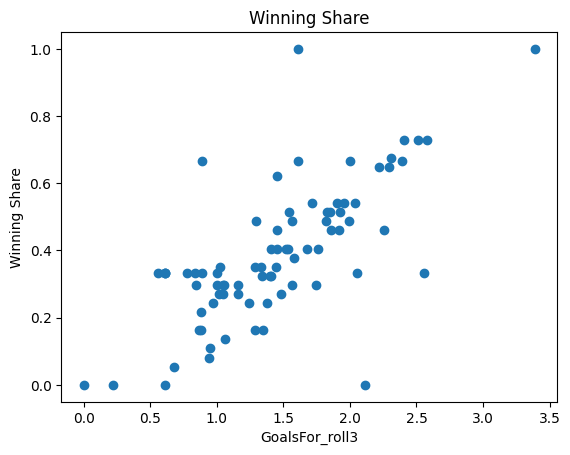

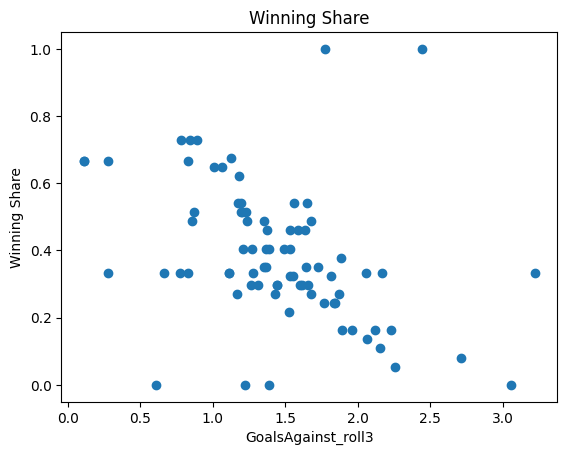

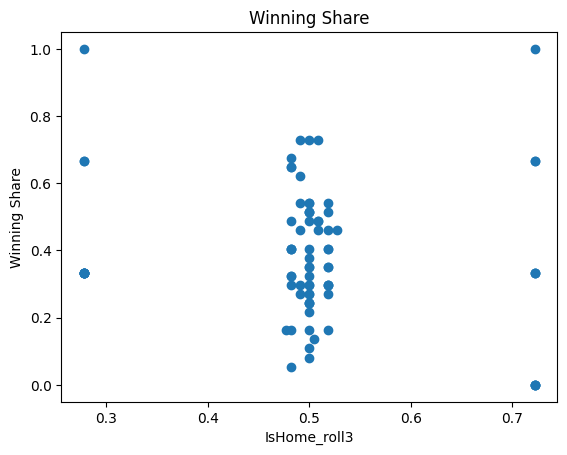

In [61]:
data_table = long_df[['Season','TeamID','Outcome', 'GoalsFor_roll3', 'GoalsAgainst_roll3', 'IsHome_roll3']].dropna()
data_table.loc[:, 'Win'] = 0
data_table.loc[data_table['Outcome'] == 'W', 'Win'] = 1
data_table = data_table.groupby(['Season', 'TeamID']).agg(Win = ('Win', 'mean'),
                                                          IsHome_roll3 = ('IsHome_roll3', 'mean'),
                                                          GoalsFor_roll3 = ('GoalsFor_roll3', 'mean'),
                                                          GoalsAgainst_roll3 = ('GoalsAgainst_roll3', 'mean')
                                                          ).reset_index()
cols = ['GoalsFor_roll3', 'GoalsAgainst_roll3', 'IsHome_roll3']
for col in cols:
    plt.scatter(x=data_table[col], y=data_table['Win'])

    plt.xlabel(f'{col}')
    plt.ylabel('Winning Share')
    plt.title('Winning Share')
    plt.show()

Distribution of outcomes for home games

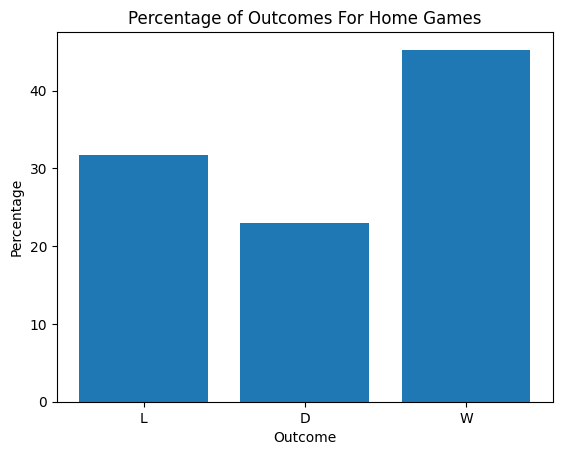

In [62]:
# for season in long_df['Season'].unique():
ishome_stats = long_df.groupby(['IsHome', 'Outcome']).agg(num=('TeamID', 'count')).reset_index()
ishome_stats = ishome_stats[ishome_stats['IsHome'] == True]

desired_order = ['L', 'D', 'W']
ishome_stats['Outcome'] = pd.Categorical(ishome_stats['Outcome'], categories=desired_order, ordered=True)
ishome_stats = ishome_stats.sort_values('Outcome').reset_index(drop=True)

# Calculate the percentage of each outcome
ishome_stats['percent'] = ishome_stats['num'] / ishome_stats['num'].sum() * 100

# Plot the horizontal bar chart
plt.bar(ishome_stats['Outcome'], ishome_stats['percent'])
plt.xlabel('Outcome')
plt.ylabel('Percentage')
plt.title(f'Percentage of Outcomes For Home Games')
plt.show()


# Estimation

## Estimate the K-Nearest Neighbour Model

In [76]:
roll3_cols = [col for col in long_df.columns if col.endswith('_roll3')]
estimation_data = long_df[['Outcome', 'Week', 'IsHome'] + roll3_cols].dropna().copy()

X = estimation_data[['Week', 'IsHome'] + roll3_cols].astype(float)

# encode target to integers (e.g. {'D':0,'L':1,'W':2} depending on classes present)
le = LabelEncoder()
y = le.fit_transform(estimation_data['Outcome'])
label_mapping = {cls: int(i) for i, cls in enumerate(le.classes_)}
print("Label mapping:", label_mapping)

# train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# optional: scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

# Fitting the models.
# knn classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# logistic regression
log_reg = LogisticRegression(penalty=None)
log_reg.fit(X_train, y_train)

long_df['Predicted_knn'] = knn.predict(scaler.transform(long_df[['Week', 'IsHome'] + roll3_cols].astype(float).fillna(-1)))
long_df['Predicted_logreg'] = log_reg.predict(scaler.transform(long_df[['Week', 'IsHome'] + roll3_cols].astype(float).fillna(-1)))

# Comparing accuracy on the validation set.
print("KNN: ",accuracy_score(y_test, knn.predict(X_test)))
print("Logistic Regression: ",accuracy_score(y_test, log_reg.predict(X_test)))

Label mapping: {'D': 0, 'L': 1, 'W': 2}
X_train shape: (1824, 5) y_train shape: (1824,)
X_test shape: (456, 5) y_test shape: (456,)
KNN:  0.40350877192982454
Logistic Regression:  0.48464912280701755


In [77]:
long_df[(long_df['Season'] == '2025-2026') & (long_df['Week'] == 5)]

,Season,MatchID,MatchDate,Week,year,month,day,Team,TeamID,IsHome,...,Points,IsHome_lag1,GoalsFor_lag1,GoalsAgainst_lag1,Outcome_lag1,IsHome_roll3,GoalsFor_roll3,GoalsAgainst_roll3,Predicted_knn,Predicted_logreg
2284,2025-2026,1190,2025-09-21,5,2025,9,21,Arsenal,1,True,...,NaN,True,3.0,0.0,W,0.666667,2.666667,0.333333,1,2
2322,2025-2026,1188,2025-09-21,5,2025,9,21,Aston Villa,2,False,...,NaN,False,0.0,0.0,D,0.333333,0.000000,1.333333,1,1
2360,2025-2026,1189,2025-09-21,5,2025,9,21,Bournemouth,3,True,...,NaN,True,2.0,1.0,W,0.666667,1.333333,0.333333,0,2
2398,2025-2026,1187,2025-09-20,5,2025,9,20,Brentford,4,False,...,NaN,True,2.0,2.0,D,0.666667,1.333333,1.333333,1,1
2436,2025-2026,1183,2025-09-20,5,2025,9,20,Brighton,5,True,...,NaN,False,1.0,2.0,L,0.333333,1.000000,1.666667,1,2
2474,2025-2026,1184,2025-09-20,5,2025,9,20,Burnley,6,True,...,NaN,True,0.0,1.0,L,0.666667,1.333333,1.333333,1,2
2512,2025-2026,1186,2025-09-20,5,2025,9,20,Chelsea,7,False,...,NaN,False,2.0,2.0,D,0.333333,3.000000,1.000000,1,2
2550,2025-2026,1185,2025-09-20,5,2025,9,20,Crystal Palace,8,False,...,NaN,True,0.0,0.0,D,0.666667,1.333333,0.333333,1,1
2588,2025-2026,1181,2025-09-20,5,2025,9,20,Everton,9,False,...,NaN,True,0.0,0.0,D,0.666667,1.666667,0.666667,0,1
2626,2025-2026,1187,2025-09-20,5,2025,9,20,Fulham,10,True,...,NaN,True,1.0,0.0,W,0.666667,0.666667,1.000000,2,2
